In [30]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
ls

drive/  sample_data/


In [10]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv", names=['target', 'ids', 'date', 'flag', 'user', 'text'],
                encoding='latin-1', error_bad_lines=False)

In [11]:
##downsample to 100k 50/50 split

down_sample = 100000

neg_index = np.random.choice(df[df.target == 0].index, size=int(.5*down_sample), replace=False)
pos_index = np.random.choice(df[df.target == 4].index, size=int(.5*down_sample), replace=False)

red_index = np.concatenate((neg_index, pos_index))

downsample = df.iloc[red_index,:]

In [12]:
downsample.head()

,target,ids,date,flag,user,text
411190,0,2060050962,Sat Jun 06 18:09:48 PDT 2009,NO_QUERY,Shaun_Meloy,@PhillyD http://twitpic.com/6s3to - Wish it wa...
745683,0,2282508964,Mon Jun 22 11:27:32 PDT 2009,NO_QUERY,KComer,@ladyw87 i want sleep as well!!! this day need...
239012,0,1980534862,Sun May 31 07:00:56 PDT 2009,NO_QUERY,lheadapohl,The bad cousin doesn't deserve a strawberry bu...
325365,0,2007087454,Tue Jun 02 12:07:40 PDT 2009,NO_QUERY,ggf13,@LaurenConrad yaa i could barely hear anything
365590,0,2048575438,Fri Jun 05 15:25:32 PDT 2009,NO_QUERY,crawf008,@beachinbiggs wish i was slavin with you


In [13]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.target = df.target.apply(lambda x: label_decoder(x))
df.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
df['target'].value_counts(normalize=True)

Negative    0.5
Positive    0.5
Name: target, dtype: float64

Text(0.5, 1.0, 'Distribution of data')

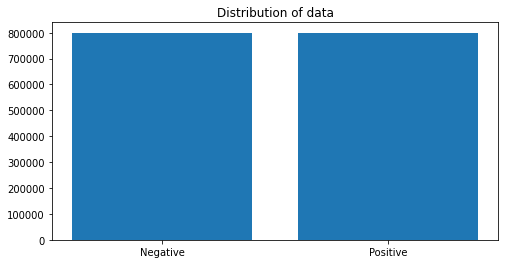

In [15]:
##Distribution of labels

val_count = df.target.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Distribution of data")

In [16]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [17]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [18]:
df.text = df.text.apply(lambda x: preprocess(x))


In [20]:
df['text'] = df['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['text'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,"'get',",71287
1,"'like',",67324
2,"'day',",65471
3,"'go',",62511
4,"'good',",59505
5,"'quot',",59345
6,"'amp',",46999
7,"'today',",45719
8,"'u',",45604
9,"'work',",44896


In [21]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [23]:
Positive_sent = df[df['target']=='Positive']
Negative_sent = df[df['target']=='Negative']


In [24]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,"'good',",39177
1,"'quot',",37268
2,"'day',",34614
3,"'love',",31276
4,"'get',",30891
5,"'like',",30813
6,"'u',",26054
7,"'amp',",25360
8,"'go',",23530
9,"'new',",23097


In [26]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['text'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,"'go',",38981
2,"'like',",36511
3,"'day',",30857
4,"'work',",30416
5,"'today',",25506
6,"'going',",25036
7,"'back',",24985
8,"'got',",23607
9,"'im',",22780
10,"'really',",22473


In [27]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [40]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '/content/drive/MyDrive/Colab Notebooks/'

In [41]:
pos_mask = np.array(Image.open(d+ 'twitter.png'))

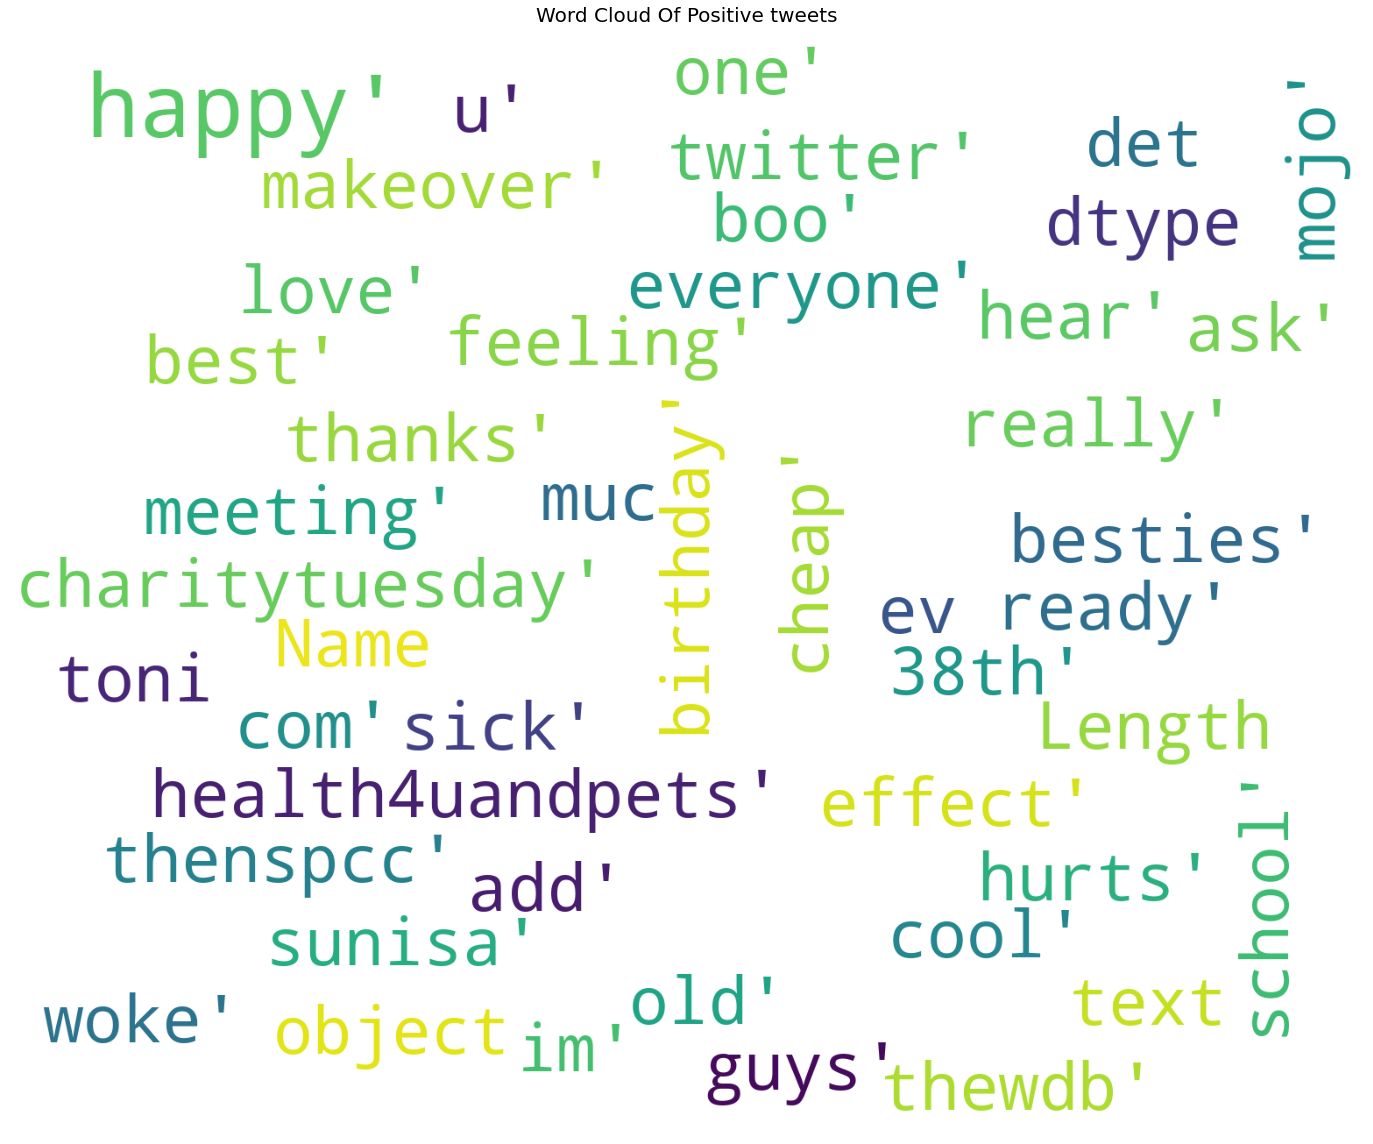

In [43]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=20)
#plot_wordcloud(Positive_sent.text,title="Word Cloud Of Positive tweets",title_size=30)

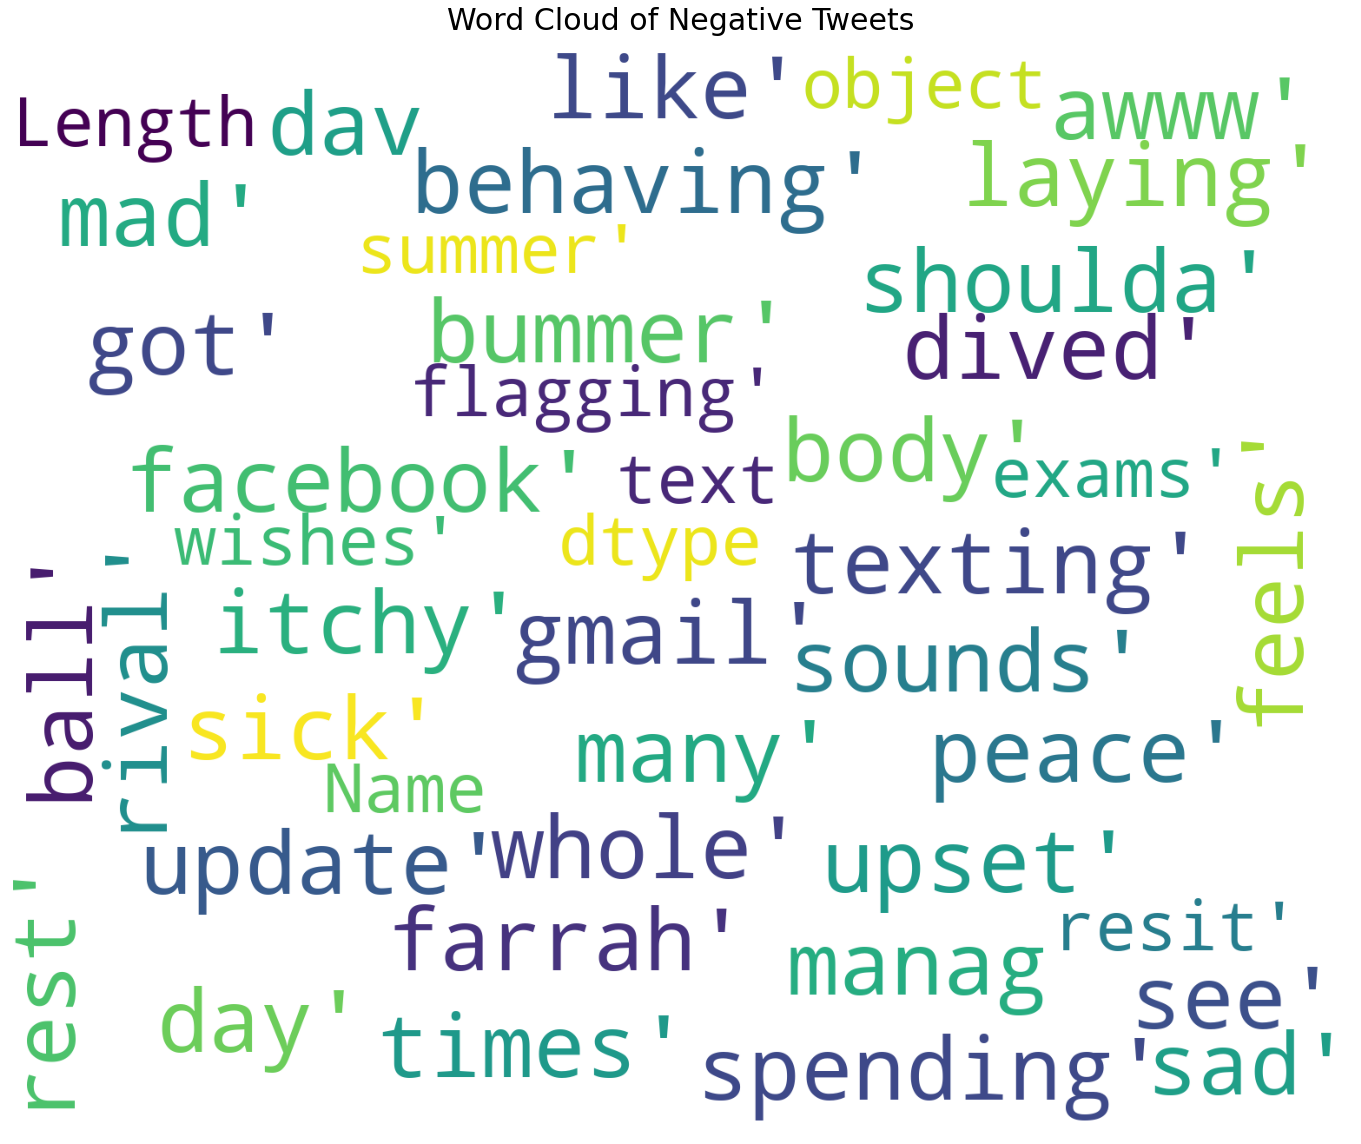

In [44]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets",color='white',title_size=30)

In [45]:
downsample['length']=downsample['text'].apply(len)

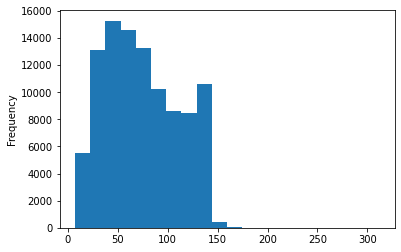

In [46]:
downsample['length'].plot(bins=20,kind='hist')